#Script that attempts to located highest values of NDVI from images located in Drive

#  NDVI and True Color Image Analysis – Garissa, 2023

This notebook performs a full NDVI (Normalized Difference Vegetation Index) analysis using satellite imagery from Garissa in 2023. The objective is to identify areas with the highest vegetation health and visualize them alongside true color images for contextual understanding.

---

##  Mounting Google Drive

First, the Google Drive is mounted to access all NDVI and true color image files stored in specific directories.

---

##  Displaying NDVI and True Color Images Side-by-Side

A function is created to display each NDVI image next to its corresponding true color image. Both images are resized to match dimensions, corrected for color representation, and shown together using a two-panel layout. This visual comparison helps assess the alignment between NDVI measurements and true color satillite image. Thsi function can be called in such a manner:
```python
display_images_side_by_side(ndvi_path, true_color_path)
```


---

##  Extracting Top NDVI Values from Each Image

All NDVI image CSV files are loaded and converted into arrays. For each image:
- The top 10 highest NDVI values are identified
- Their pixel positions are calculated
- A heatmap is generated to visualize these top NDVI spots, with red dots marking the highest values- this output should be ignored however because of scaling issues

This step helps visually identify the "greenest" areas in each satellite snapshot.

---

##  Examining the NDVI Data for Quality

Each CSV is briefly examined to evaluate its structure and data quality. Many contain large regions of zero or invalid values. Based on this inspection, April 20, 2023 is selected as a representative day with high-quality NDVI data.

---

##  Analyzing April 20th NDVI Image in Detail

For the April 20 image:
- The corresponding NDVI image and CSV are loaded
- Only valid NDVI values (between -1 and 1) are used
- The top 50 highest NDVI pixels are identified
- Their locations are scaled to match the image dimensions using the following code:
```python
scaled_cols = (top_cols / cols_csv) * img_width
scaled_rows = (top_rows / rows_csv) * img_height
```

- Red dots are overlaid on both the NDVI and the true color image to show where the healthiest vegetation occurred (next step)



---

##  Getting the Top NDVI Pixels

The top 50 NDVI values and their corresponding row and column indices are tabulated into a clean output. This can later be used for spatial analysis or mapping if the pixel grid is georeferenced.

Next, an image is generated with an overlay of the top 50 NDVI spots in red over the NDVI image of the April 20th date.

---

## Final(ish) Output

- Overlay of these NDVI hotspots on both the NDVI and true color images



In [ ]:
#mounting and connecting drive to the workspace
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 #displays NDVI and true color next to each other with the true color images in /GarissaData/2023/TrueColor-2023

import matplotlib.pyplot as plt
import cv2
import glob
import numpy as np

#defines a function to handle all the images instead of doing it manually for each image
def display_images_side_by_side(ndvi_image_path, true_color_image_path):
  """
  Displays two images side by side using matplotlib.

  Args:
    ndvi_image_path: Path to the NDVI image.
    true_color_image_path: Path to the true color image.
  """
#reads in both the true color image and the ndvi image
  ndvi_image = cv2.imread(ndvi_image_path)
  true_color_image = cv2.imread(true_color_image_path)

  # Ensure both images have the same dimensions (e.g., resize if needed)
  if ndvi_image.shape != true_color_image.shape:
    true_color_image = cv2.resize(true_color_image, (ndvi_image.shape[1], ndvi_image.shape[0]))

  # Display images side by side
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

#fixes the color and displays with proper corresponding titles
  axs[0].imshow(cv2.cvtColor(ndvi_image, cv2.COLOR_BGR2RGB))
  axs[0].set_title("NDVI Image")

  axs[1].imshow(cv2.cvtColor(true_color_image, cv2.COLOR_BGR2RGB))
  axs[1].set_title("True Color Image")

  plt.show()


# Get a list of NDVI and true color image paths
ndvi_image_paths = glob.glob('/content/drive/MyDrive/GarissaData/2023/NDVIimgs/*.png')
true_color_image_paths = glob.glob('/content/drive/MyDrive/GarissaData/2023/True Color- 2023/*.png')

# Sort image paths to ensure corresponding images are displayed together
ndvi_image_paths.sort()
true_color_image_paths.sort()

# Display image pairs
for ndvi_path, true_color_path in zip(ndvi_image_paths, true_color_image_paths):
  display_images_side_by_side(ndvi_path, true_color_path)#calls function iteratively with the loop



Output hidden; open in https://colab.research.google.com to view.

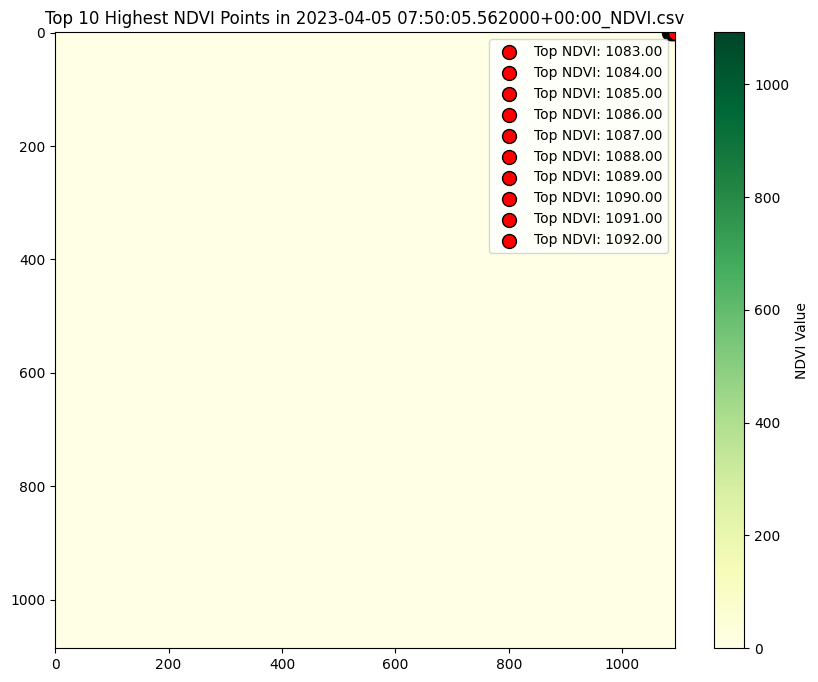

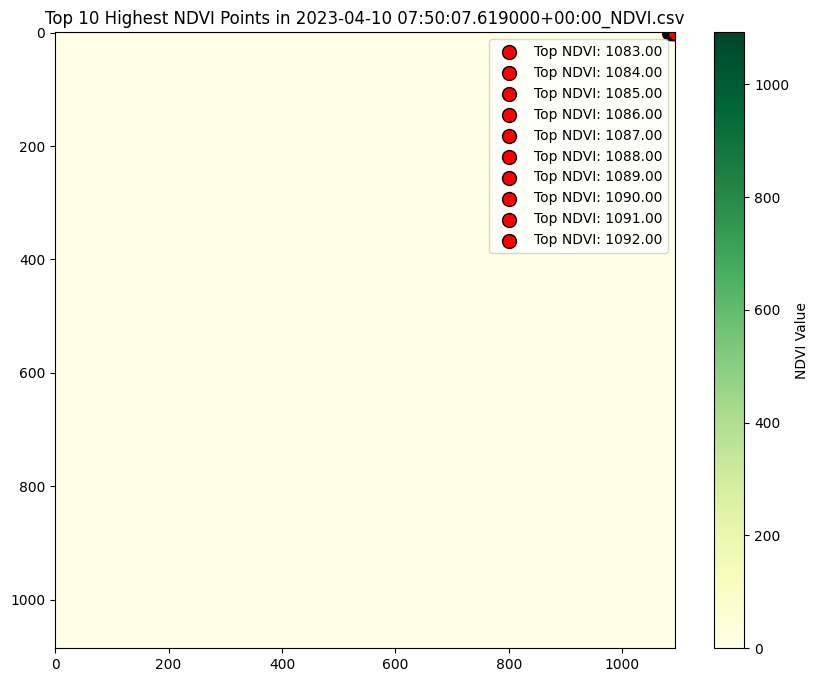

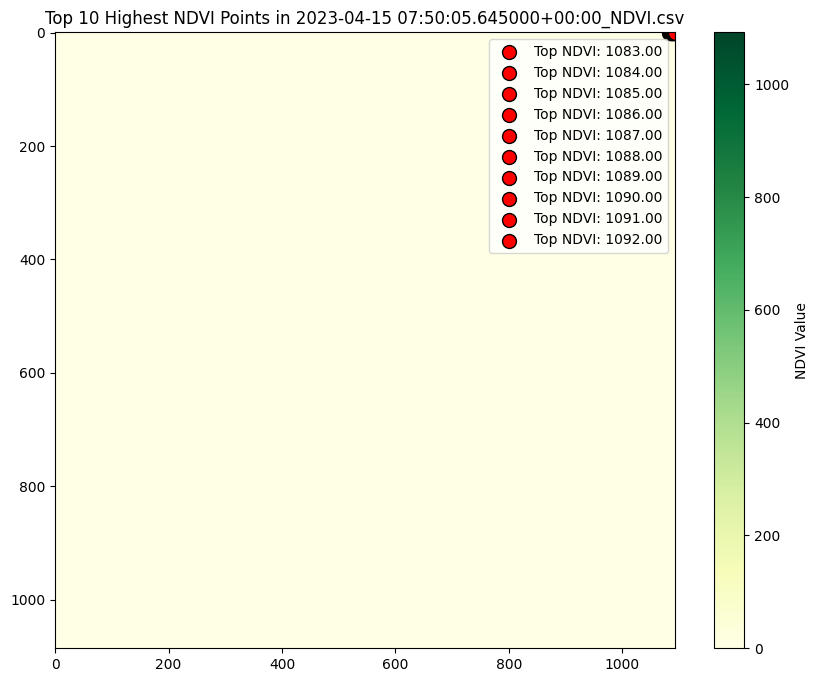

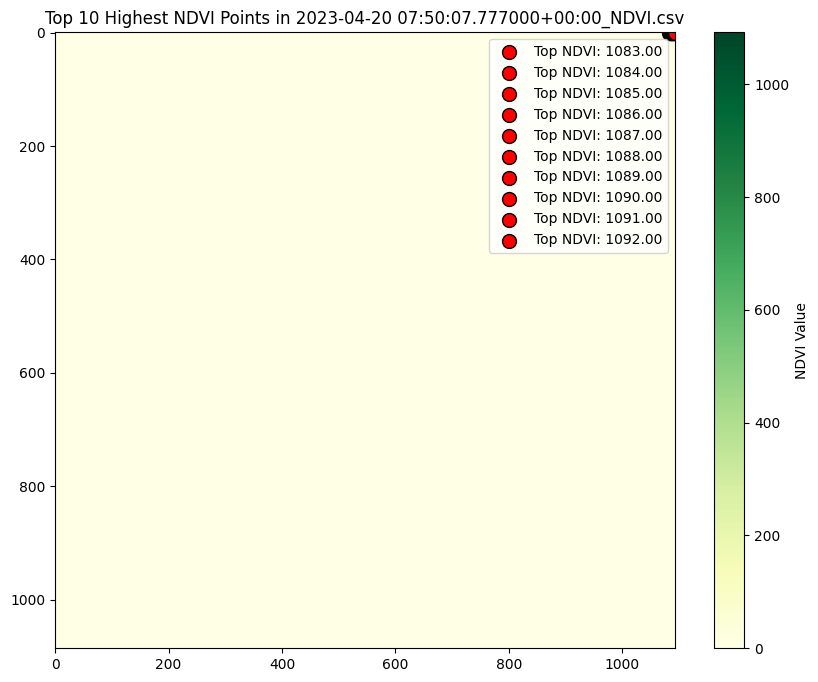

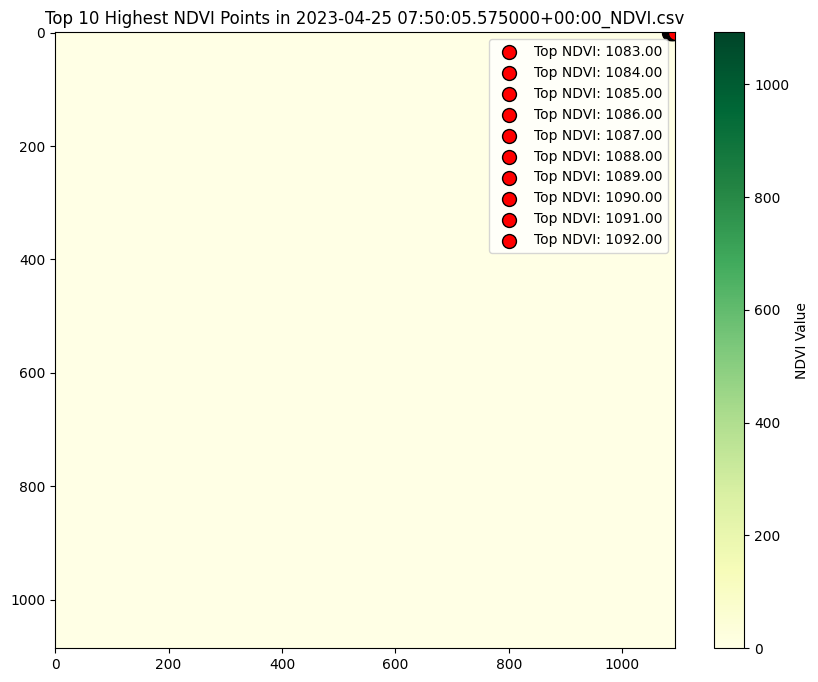

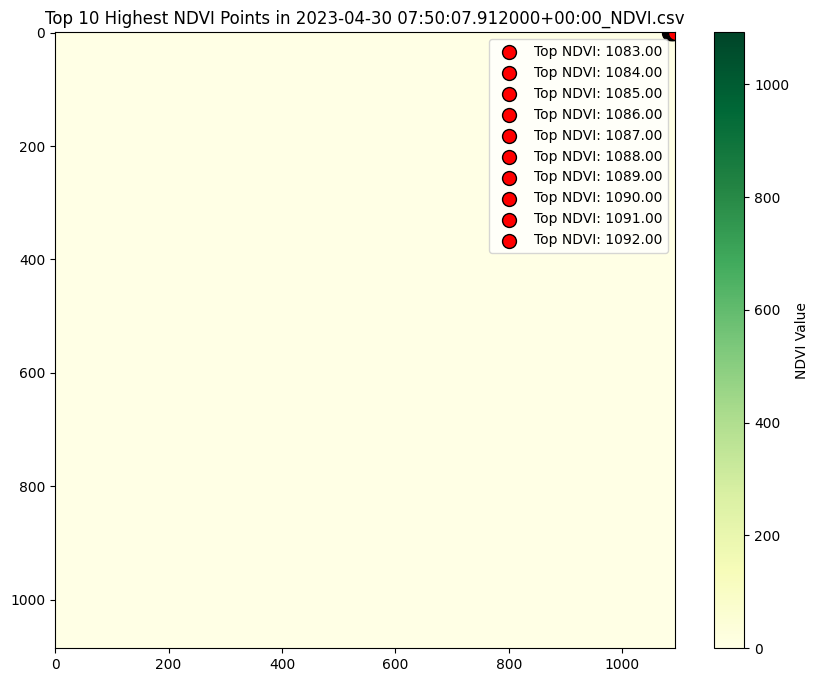

In [ ]:
#an attempt to locate the highest value of NDVI in a given image, we use the 2023 Garissa data here

#load proper packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# Path to the NDVI CSV files
ndvi_image_paths = glob.glob('/content/drive/MyDrive/GarissaData/2023/NDVI-2023csvs/*.csv')

# Function to process NDVI files and find highest NDVI points
def process_ndvi_files(ndvi_image_paths, top_n=10):
    for path in ndvi_image_paths:
        # Read the CSV
        df = pd.read_csv(path, header=None)

        # Convert the dataframe to a numpy array for easier manipulation
        ndvi_array = df.to_numpy()

        # Find the top N highest NDVI values and their positions
        flat_indices = np.argsort(ndvi_array, axis=None)[-top_n:]  # Get indices of top N highest NDVI
        top_values = ndvi_array.flatten()[flat_indices]  # Get actual NDVI values at those positions
        top_positions = np.unravel_index(flat_indices, ndvi_array.shape)  # Convert indices to row, col positions

        # Plotting the NDVI grid and marking the top N points
        plt.figure(figsize=(10, 8))
        plt.imshow(ndvi_array, cmap='YlGn', interpolation='nearest')  # Display NDVI grid
        plt.colorbar(label='NDVI Value')

        # Marking the top N positions with circles
        for row, col in zip(*top_positions):
            plt.scatter(col, row, color='red', s=100, edgecolors='black', label=f"Top NDVI: {ndvi_array[row, col]:.2f}")

        plt.title(f"Top {top_n} Highest NDVI Points in {path.split('/')[-1]}")
        plt.legend(loc='upper right')
        plt.show()

# Process NDVI files and find the top 10 highest NDVI points
process_ndvi_files(ndvi_image_paths, top_n=10)





In [ ]:
#looking at the actial values of the csvs, notice that there is much "bad" data (0 values everywhere)
import pandas as pd
import glob

# Function to examine the structure of the CSV files
def examine_csv_structure(ndvi_image_paths):
    for path in ndvi_image_paths:
        print(f"Examining file: {path}")
        df = pd.read_csv(path)
        print(df.head())  # Print the first few rows to see the structure

# Path to the NDVI CSV files
ndvi_image_paths = glob.glob('/content/drive/MyDrive/GarissaData/2023/NDVI-2023csvs/*.csv')

# Examine the structure of the NDVI CSVs
examine_csv_structure(ndvi_image_paths)


Examining file: /content/drive/MyDrive/GarissaData/2023/NDVI-2023csvs/2023-04-05 07:50:05.562000+00:00_NDVI.csv
     0    1    2    3    4    5    6         7         8         9  ...  1083  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.643533  0.644214  0.597851  ...   0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.632466  0.623322  0.567701  ...   0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.626154  0.658842  0.623863  ...   0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.646091  0.567588  0.571270  ...   0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.665593  0.625706  0.602627  ...   0.0   

   1084  1085  1086  1087  1088  1089  1090  1091  1092  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 1093 columns]
Examining file: /content/dri

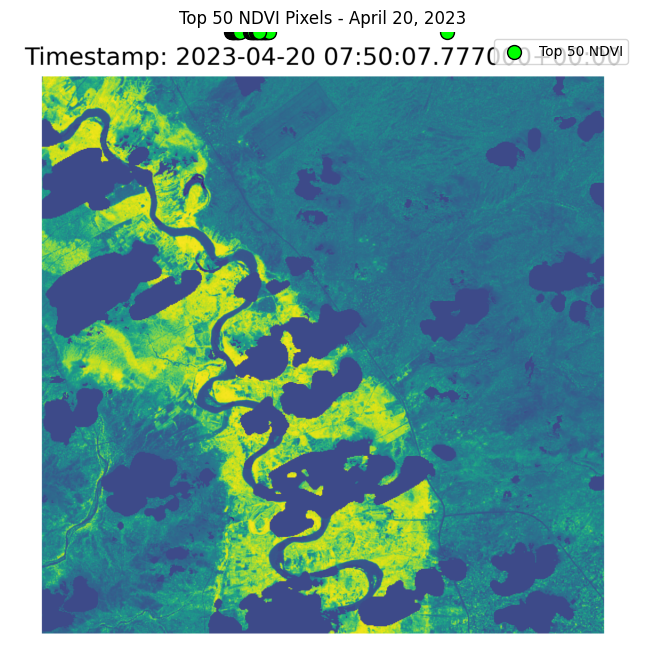

In [ ]:
#identified April 20th, 2023 as the best usable data, script to identify the highest NDVI values (top 50) from this specific image

#import proper packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image

# Load April 20th NDVI CSV and image
csv_path = glob.glob('/content/drive/MyDrive/GarissaData/2023/NDVI-2023csvs/*2023-04-20*.csv')
image_path = glob.glob('/content/drive/MyDrive/GarissaData/2023/NDVIimgs/*2023-04-20*.png')

if csv_path and image_path:
    csv_path = csv_path[0]
    image_path = image_path[0]

    # Read NDVI CSV
    df = pd.read_csv(csv_path, header=None)
    ndvi_array = df.to_numpy()
    rows_csv, cols_csv = ndvi_array.shape

    # Mask out invalid NDVI values
    mask = (ndvi_array >= -1) & (ndvi_array <= 1)
    valid_ndvi = np.where(mask, ndvi_array, np.nan)

    # Get top 50 highest NDVI values
    flat_indices = np.argsort(valid_ndvi, axis=None)[-50:]
    top_rows, top_cols = np.unravel_index(flat_indices, valid_ndvi.shape)

    # Load NDVI image
    ndvi_img = np.array(Image.open(image_path))
    img_height, img_width = ndvi_img.shape[:2]

    # Scale pixel coordinates from CSV to image size
    scaled_cols = (top_cols / cols_csv) * img_width
    scaled_rows = (top_rows / rows_csv) * img_height

    # Plot image and top NDVI points
    plt.figure(figsize=(10, 8))
    plt.imshow(ndvi_img, origin='upper')  # Ensure top of image is y=0
    plt.scatter(scaled_cols, scaled_rows, color='lime', s=100, edgecolors='black', label='Top 50 NDVI')
    plt.title("Top 50 NDVI Pixels - April 20, 2023")
    plt.axis('off')
    plt.legend()
    plt.show()
else:
    print("NDVI CSV or image for April 20 not found.")


Top 50 NDVI Pixels - April 20, 2023
 Row  Column  NDVI Value
   0       1    1.000000
 523     477    0.924320
 127     139    0.924300
 589     301    0.922819
 274     279    0.922704
 273     281    0.922326
 122     140    0.921610
 125     138    0.920671
  51     142    0.920494
 285     294    0.920119
 286     274    0.919294
 583     302    0.919036
 584     302    0.918929
 273     279    0.918708
 122     138    0.918625
 540     364    0.918499
 285     295    0.918420
 273     280    0.918306
 453     491    0.918041
 602     305    0.917900
 316     265    0.917871
 281     271    0.917767
 603     305    0.917241
 340     299    0.917107
   8      20    0.916902
 284     293    0.916838
 453     490    0.916770
 523     478    0.916744
 523     479    0.916652
 287     273    0.916589
 126     139    0.916584
 127     140    0.916529
 325     275    0.916430
 615     359    0.916338
 325     274    0.916286
 127     137    0.916263
1074     638    0.916230
  50     142  

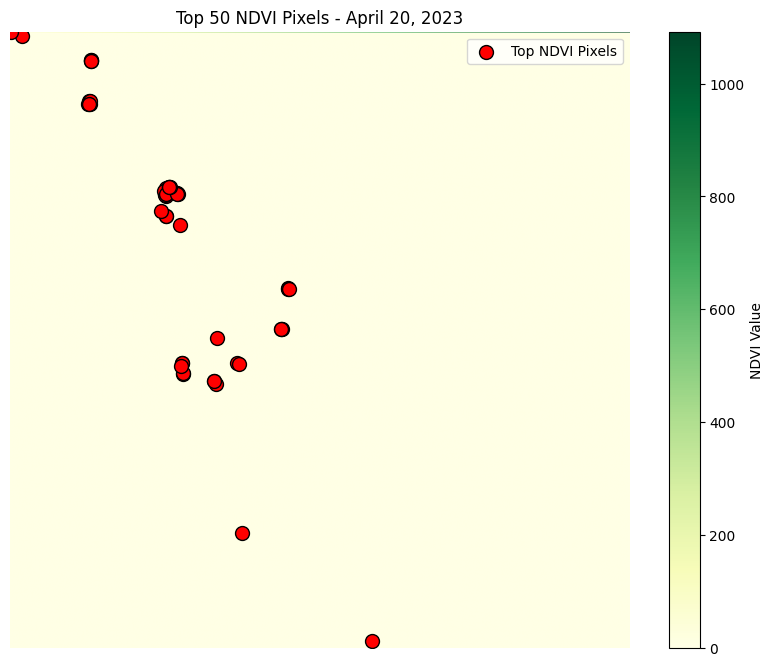

In [ ]:
#displaying what those top 50 NDVI values are and what row they correspond to - could map to geolocation too
#ignore the graph, scaling issues

#import proper packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# Load the NDVI CSV file for April 20, 2023
csv_path = glob.glob('/content/drive/MyDrive/GarissaData/2023/NDVI-2023csvs/*2023-04-20*.csv')

if csv_path:
    csv_path = csv_path[0]
    ndvi_array = pd.read_csv(csv_path, header=None).to_numpy()

    # Flatten the array while ignoring NaNs and invalid values
    valid_mask = (ndvi_array >= -1) & (ndvi_array <= 1)
    valid_indices = np.where(valid_mask)

    # Extract valid NDVI values
    valid_values = ndvi_array[valid_indices]

    # Get indices of the top N NDVI values
    top_n = 50
    top_valid_indices = np.argsort(valid_values)[-top_n:]

    # Extract top rows, columns, and values
    top_rows = valid_indices[0][top_valid_indices]
    top_cols = valid_indices[1][top_valid_indices]
    top_values = valid_values[top_valid_indices]

    # Create a DataFrame of results
    result_df = pd.DataFrame({
        'Row': top_rows,
        'Column': top_cols,
        'NDVI Value': top_values
    }).sort_values(by='NDVI Value', ascending=False)

    # Display the result table
    print("Top 50 NDVI Pixels - April 20, 2023")
    print(result_df.to_string(index=False))

    # Plot NDVI heatmap with top values marked
    plt.figure(figsize=(10, 8))
    plt.imshow(ndvi_array, cmap='YlGn', origin='upper')
    plt.colorbar(label='NDVI Value')
    plt.scatter(top_cols, top_rows, color='red', s=100, edgecolors='black', label='Top NDVI Pixels')
    plt.title("Top 50 NDVI Pixels - April 20, 2023")
    plt.legend()
    plt.axis('off')
    plt.show()

else:
    print("NDVI CSV for April 20 not found.")


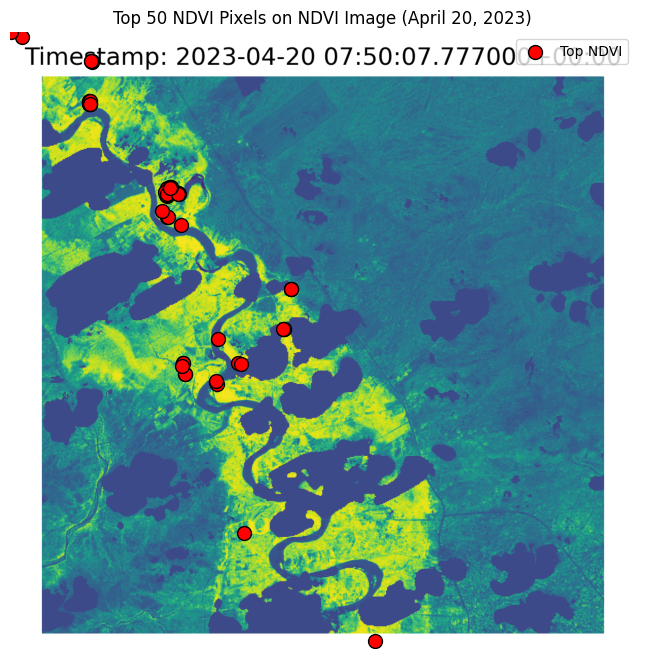

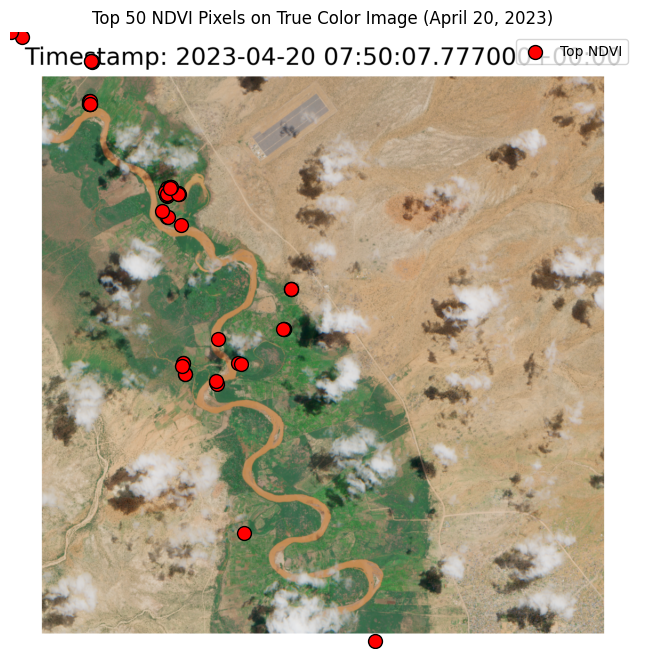

In [ ]:
#still scaling issues, but attempting to overlay these dots which correspond to the top 50 pixels onto the NDVI map and then the true color map

#importing proper packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image

# Loading April 20th NDVI CSV and images- previously saved via march9processing
csv_path = glob.glob('/content/drive/MyDrive/GarissaData/2023/NDVI-2023csvs/*2023-04-20*.csv')
ndvi_img_path = glob.glob('/content/drive/MyDrive/GarissaData/2023/NDVIimgs/*2023-04-20*.png')
true_img_path = glob.glob('/content/drive/MyDrive/GarissaData/2023/True Color- 2023/*2023-04-20*.png')

if csv_path and ndvi_img_path and true_img_path:
    # Loading the  NDVI data
    csv_path = csv_path[0]
    ndvi_array = pd.read_csv(csv_path, header=None).to_numpy()

    # making sure/checking shapes of arrays
    rows_csv, cols_csv = ndvi_array.shape

    # Masking the  invalid NDVI values
    valid_mask = (ndvi_array >= -1) & (ndvi_array <= 1)
    valid_indices = np.where(valid_mask)
    valid_values = ndvi_array[valid_indices]

    # Finding the  top 50 NDVI pixels- to find a path?
    top_n = 50
    top_valid_indices = np.argsort(valid_values)[-top_n:]
    top_rows = valid_indices[0][top_valid_indices]
    top_cols = valid_indices[1][top_valid_indices]
    top_values = valid_values[top_valid_indices]

    # Loading the  NDVI image
    ndvi_img = np.array(Image.open(ndvi_img_path[0]))
    img_h, img_w = ndvi_img.shape[:2]

    # Scaling CSV coordinates to image size- issue here
    scaled_cols = (top_cols / cols_csv) * img_w
    scaled_rows = (top_rows / rows_csv) * img_h

#plotting the figure (for NDVI)
    plt.figure(figsize=(10, 8))
    plt.imshow(ndvi_img)
    plt.scatter(scaled_cols, scaled_rows, color='red', s=100, edgecolors='black', label='Top NDVI')
    plt.title("Top 50 NDVI Pixels on NDVI Image (April 20, 2023)")
    plt.axis('off')
    plt.legend()
    plt.show()

    #plotting but for True Color
    true_img = np.array(Image.open(true_img_path[0]))
    plt.figure(figsize=(10, 8))
    plt.imshow(true_img)
    plt.scatter(scaled_cols, scaled_rows, color='red', s=100, edgecolors='black', label='Top NDVI')
    plt.title("Top 50 NDVI Pixels on True Color Image (April 20, 2023)")
    plt.axis('off')
    plt.legend()
    plt.show()

else:
    print("Required CSV or image for April 20, 2023 not found.")
